In [ ]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [56]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import warnings
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [57]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore", category=FutureWarning)

In [58]:
train=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
# train=pd.read_csv('C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
# test=pd.read_csv('C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
data_description='/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt'
# data_description='C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt'

In [59]:
train=train.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
test=test.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])

In [61]:
nonnumeric_features=[]
for col in train.columns:
    if is_object_dtype(train[col]):
        nonnumeric_features.append(col)

In [62]:
train[nonnumeric_features].describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,1267,1198


In [63]:
train.loc[:, ~train.columns.isin(nonnumeric_features)].describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,421.61,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,1.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,365.75,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,730.50,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,1095.25,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,1460.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


In [64]:
with open(data_description, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'MSSubClass' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES



In [65]:
numeric_features=[]
for col in train.columns:
    if is_numeric_dtype(train[col]):
        numeric_features.append(col)
    else:
        pass

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [66]:
zero_data_set_sum_train=train.isnull().sum()
zero_data_set_percentage_train=train.isnull().sum()/train.shape[0]*100
zero_data_set_train=pd.DataFrame({'sum':zero_data_set_sum_train, 'percentage': zero_data_set_percentage_train})
zero=zero_data_set_train.loc[zero_data_set_train['sum']>0]

In [67]:
zero

,sum,percentage
LotFrontage,259,17.74
MasVnrType,872,59.73
MasVnrArea,8,0.55
BsmtQual,37,2.53
BsmtCond,37,2.53
BsmtExposure,38,2.60
BsmtFinType1,37,2.53
BsmtFinType2,38,2.60
Electrical,1,0.07
FireplaceQu,690,47.26


In [68]:
train[nonnumeric_features]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,NaN,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,NaN,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,WD,Normal


In [70]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

for col in zero.index:
    train2=train.copy()
    index_train=train2.loc[train2[col].isna()==False, col].index
    index_test=train2.loc[train2[col].isna()==True, col].index
    train2=train2.loc[:, ~train2.columns.isin(zero.index)]
    train2.drop(columns=['SalePrice'], inplace=True)
    y_train=train[col].loc[index_train]
    if col in nonnumeric_features:
        le_y = LabelEncoder()
        y_train=le_y.fit_transform(y_train)
    for feature in nonnumeric_features:
        if feature in train2.columns:
            le_x = LabelEncoder()
            train2[feature] = le_x.fit_transform(train2[feature])
    x_train=train2.loc[index_train]
    x_test=train2.loc[index_test]
    if x_train.shape[0]<6:
        neighbors=x_train.shape[0]
    else:
        neighbors=6
    if col in numeric_features:
        KNN_reg=KNeighborsRegressor(n_neighbors=neighbors, weights='distance')
        KNN_reg.fit(x_train,y_train)
        predictions=KNN_reg.predict(x_test)
        train.loc[index_test,col] = train.loc[index_test, col].fillna(predictions[0])
    else:
        KNN_clas=KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
        KNN_clas.fit(x_train, y_train)
        predictions=KNN_clas.predict(x_test)
        predictions_transform = le_y.inverse_transform(predictions)
        train.loc[index_test, col] = train.loc[index_test, col].fillna(predictions_transform[0])

In [71]:
zero_data_set_sum_test=test.isnull().sum()
zero_data_set_percentage_test=test.isnull().sum()/test.shape[0]*100
zero_data_set_test=pd.DataFrame({'sum':zero_data_set_sum_test, 'percentage': zero_data_set_percentage_test})
zero2=zero_data_set_test.loc[zero_data_set_test['sum']>0]
zero2

,sum,percentage
MSZoning,4,0.27
LotFrontage,227,15.56
Utilities,2,0.14
Exterior1st,1,0.07
Exterior2nd,1,0.07
MasVnrType,894,61.27
MasVnrArea,15,1.03
BsmtQual,44,3.02
BsmtCond,45,3.08
BsmtExposure,44,3.02


In [72]:
for col in zero2.index:
    train2=test.copy()
    index_train=train2.loc[train2[col].isna()==False, col].index
    index_test=train2.loc[train2[col].isna()==True, col].index
    train2=train2.loc[:, ~train2.columns.isin(zero2.index)]
    y_train=test[col].loc[index_train]
    if col in nonnumeric_features:
        le_y = LabelEncoder()
        y_train=le_y.fit_transform(y_train)
    for feature in nonnumeric_features:
        if feature in train2.columns:
            le_x = LabelEncoder()
            train2[feature] = le_x.fit_transform(train2[feature])
    x_train=train2.loc[index_train]
    x_test=train2.loc[index_test]
    if x_train.shape[0]<6:
        neighbors=x_train.shape[0]
    else:
        neighbors=6
    if col in numeric_features:
        KNN_reg=KNeighborsRegressor(n_neighbors=neighbors, weights='distance')
        KNN_reg.fit(x_train,y_train)
        predictions=KNN_reg.predict(x_test)
        test.loc[index_test,col] = test.loc[index_test, col].fillna(predictions[0])
    else:
        KNN_clas=KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
        KNN_clas.fit(x_train, y_train)
        predictions=KNN_clas.predict(x_test)
        predictions_transform = le_y.inverse_transform(predictions)
        test.loc[index_test, col] = test.loc[index_test, col].fillna(predictions_transform[0])

In [73]:
smoth_columns=[
               'LotArea',
               ]

In [74]:
for col in smoth_columns:
    q1 = np.percentile(train[col], 25)
    q3 = np.percentile(train[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    train.loc[(train[col] > upper_bound) | (train[col] < lower_bound), col] = np.nan
    train[col].interpolate(method='polynomial', order=5, inplace=True)

In [75]:
for col in smoth_columns:
    q1 = np.percentile(test[col], 25)
    q3 = np.percentile(test[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    test.loc[(test[col] > upper_bound) | (test[col] < lower_bound), col] = np.nan
    test[col].interpolate(method='polynomial', order=5, inplace=True)

In [76]:
train.loc[train['PoolArea']>0, 'PoolArea']=1
test.loc[test['PoolArea']>0, 'PoolArea']=1

In [77]:
test['BsmtFullBath']=test['BsmtFullBath'].astype(int)

In [78]:
train['allSF']=train['TotalBsmtSF']+train['1stFlrSF']+train['2ndFlrSF']
test['allSF']=test['TotalBsmtSF']+test['1stFlrSF']+test['2ndFlrSF']

In [79]:
numeric_features.append('allSF')
numeric_features.remove('TotalBsmtSF')

In [80]:
nonnumeric_features.extend([
                            'Id',
                            'BsmtFullBath',
                            ])

In [81]:
numeric_features.remove('Id')
numeric_features.remove('BsmtFullBath')

In [82]:
train[nonnumeric_features]=train[nonnumeric_features].astype('category')
test[nonnumeric_features]=test[nonnumeric_features].astype('category')

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'TotR

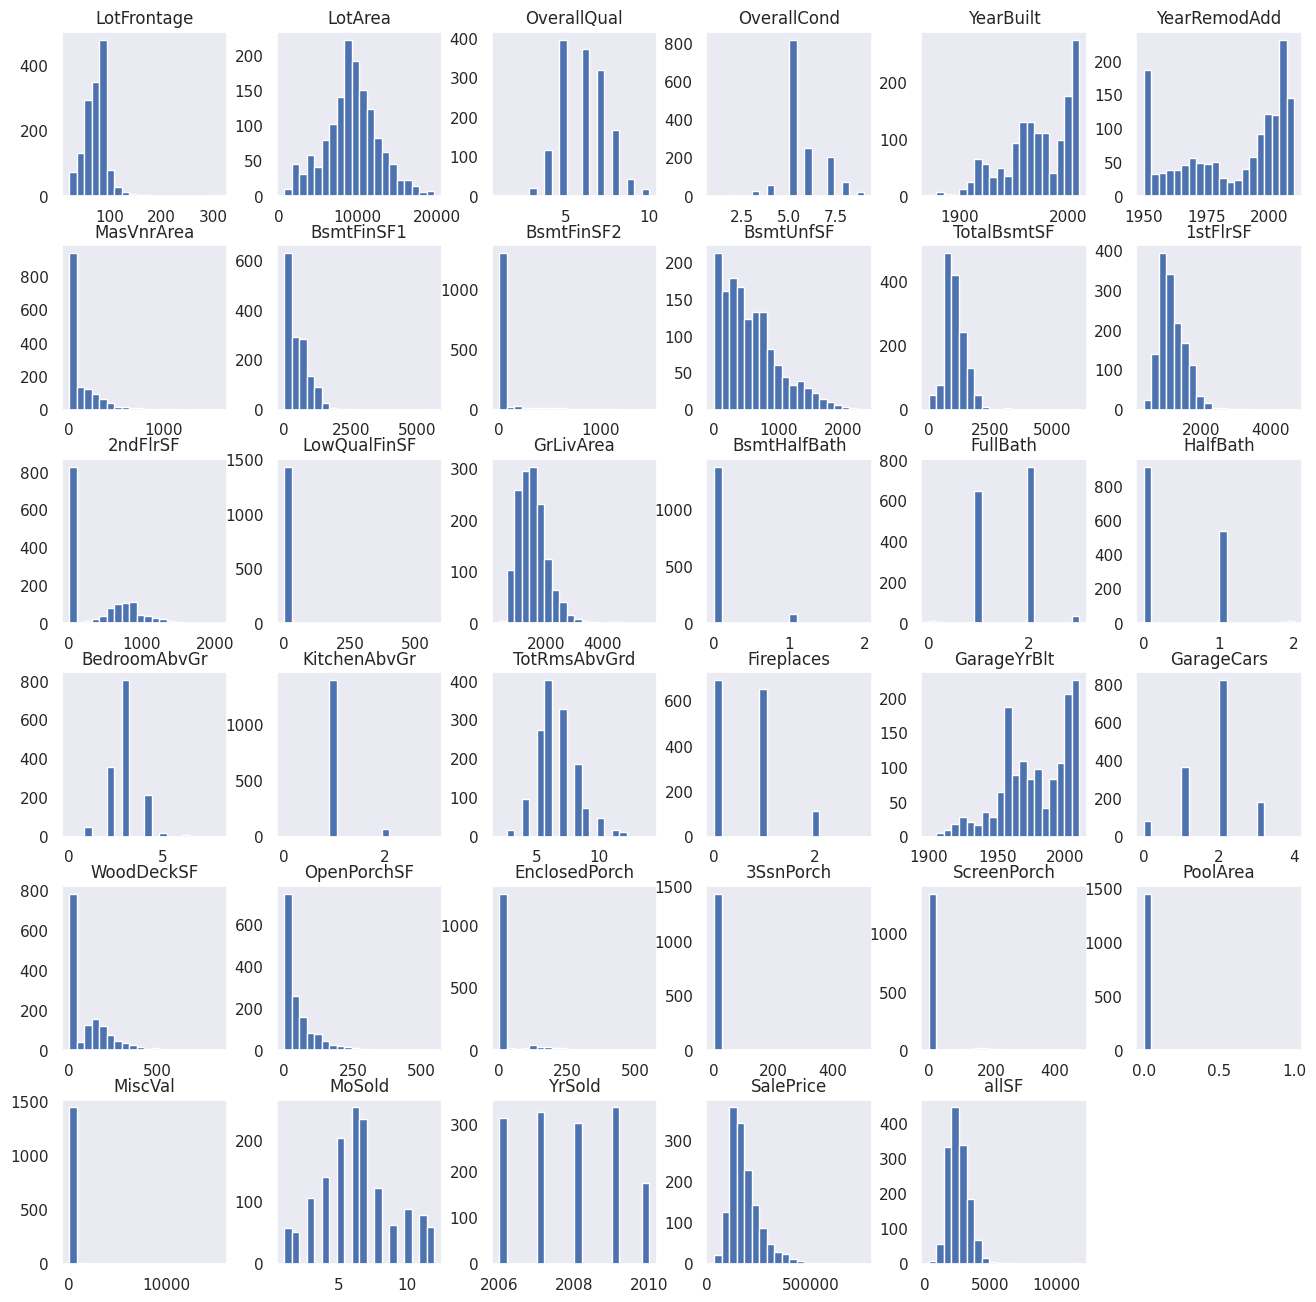

In [84]:
train.hist(figsize=(16,16), bins=20, grid=False)

In [85]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'allSF'],
      dtype='object')

In [87]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'allSF'],
      dtype='object')

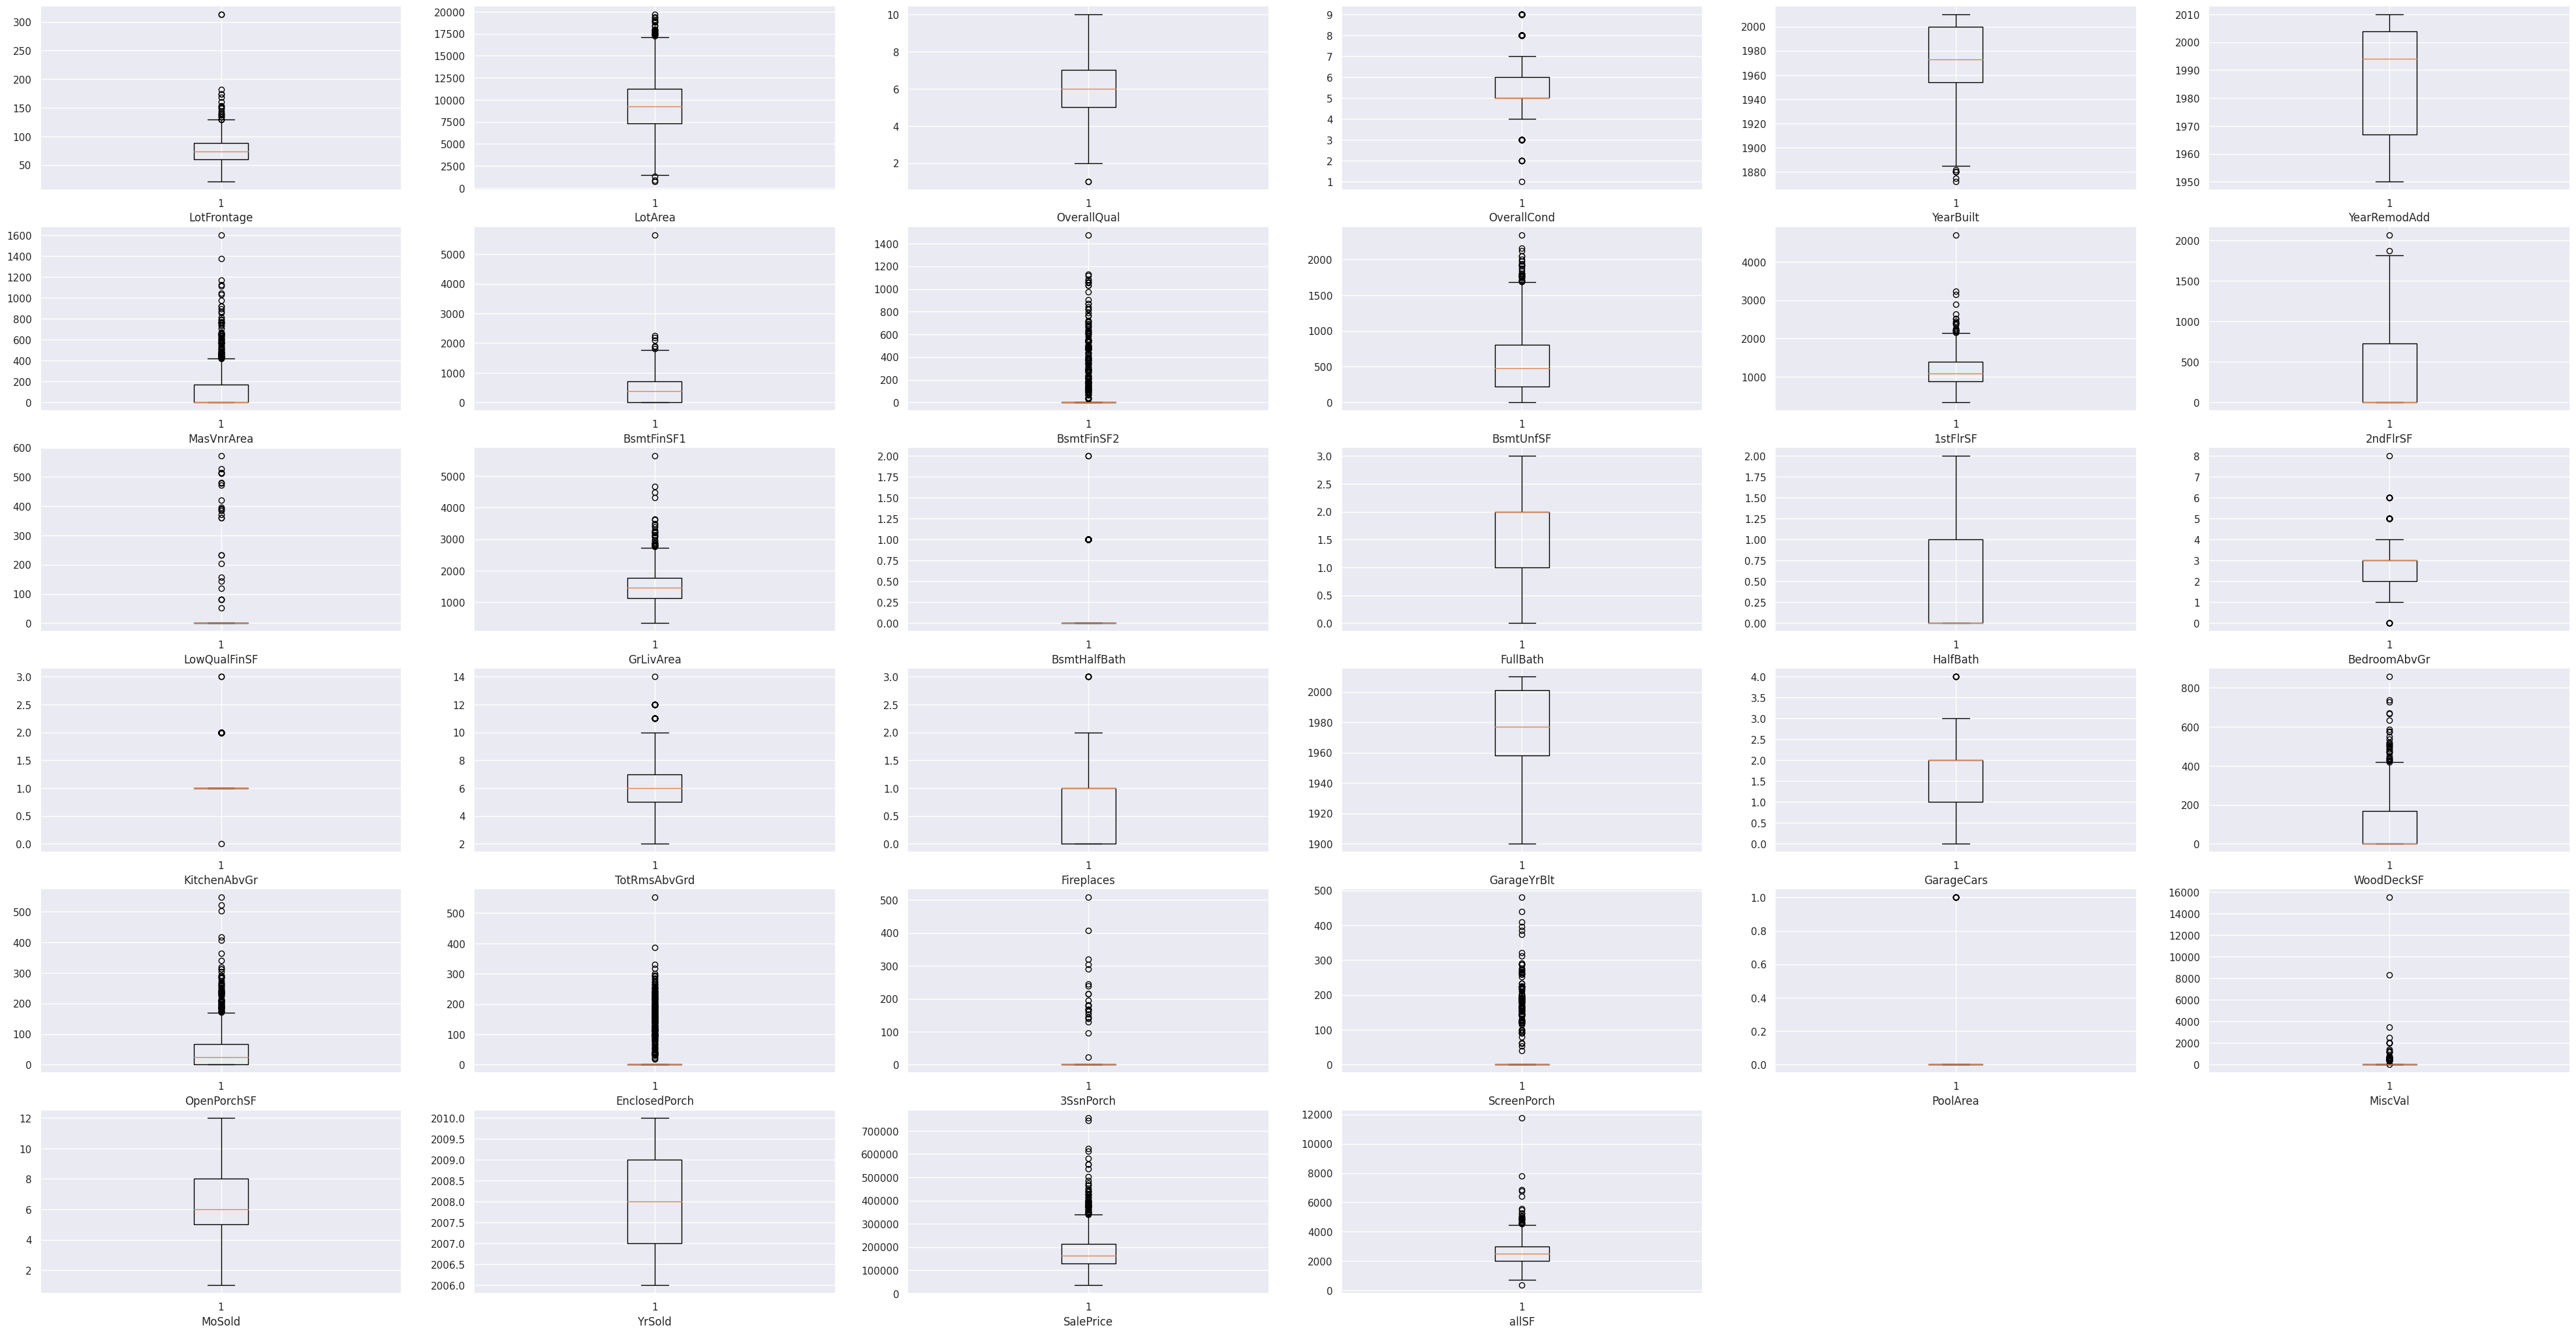

In [90]:
gs = gridspec.GridSpec(7, 6)
plt.figure(figsize=(50,30))

column=0
for i in range(7):
    column_curr=column
    for z in range(6):
        if column_curr <len(numeric_features):
            ax = plt.subplot(gs[i, z])
            ax.boxplot(train[train[numeric_features].columns[column_curr]])
            ax.set_xlabel(train[numeric_features].columns[column_curr])
            column_curr+=1
            column=column_curr
column+=7

plt.show()

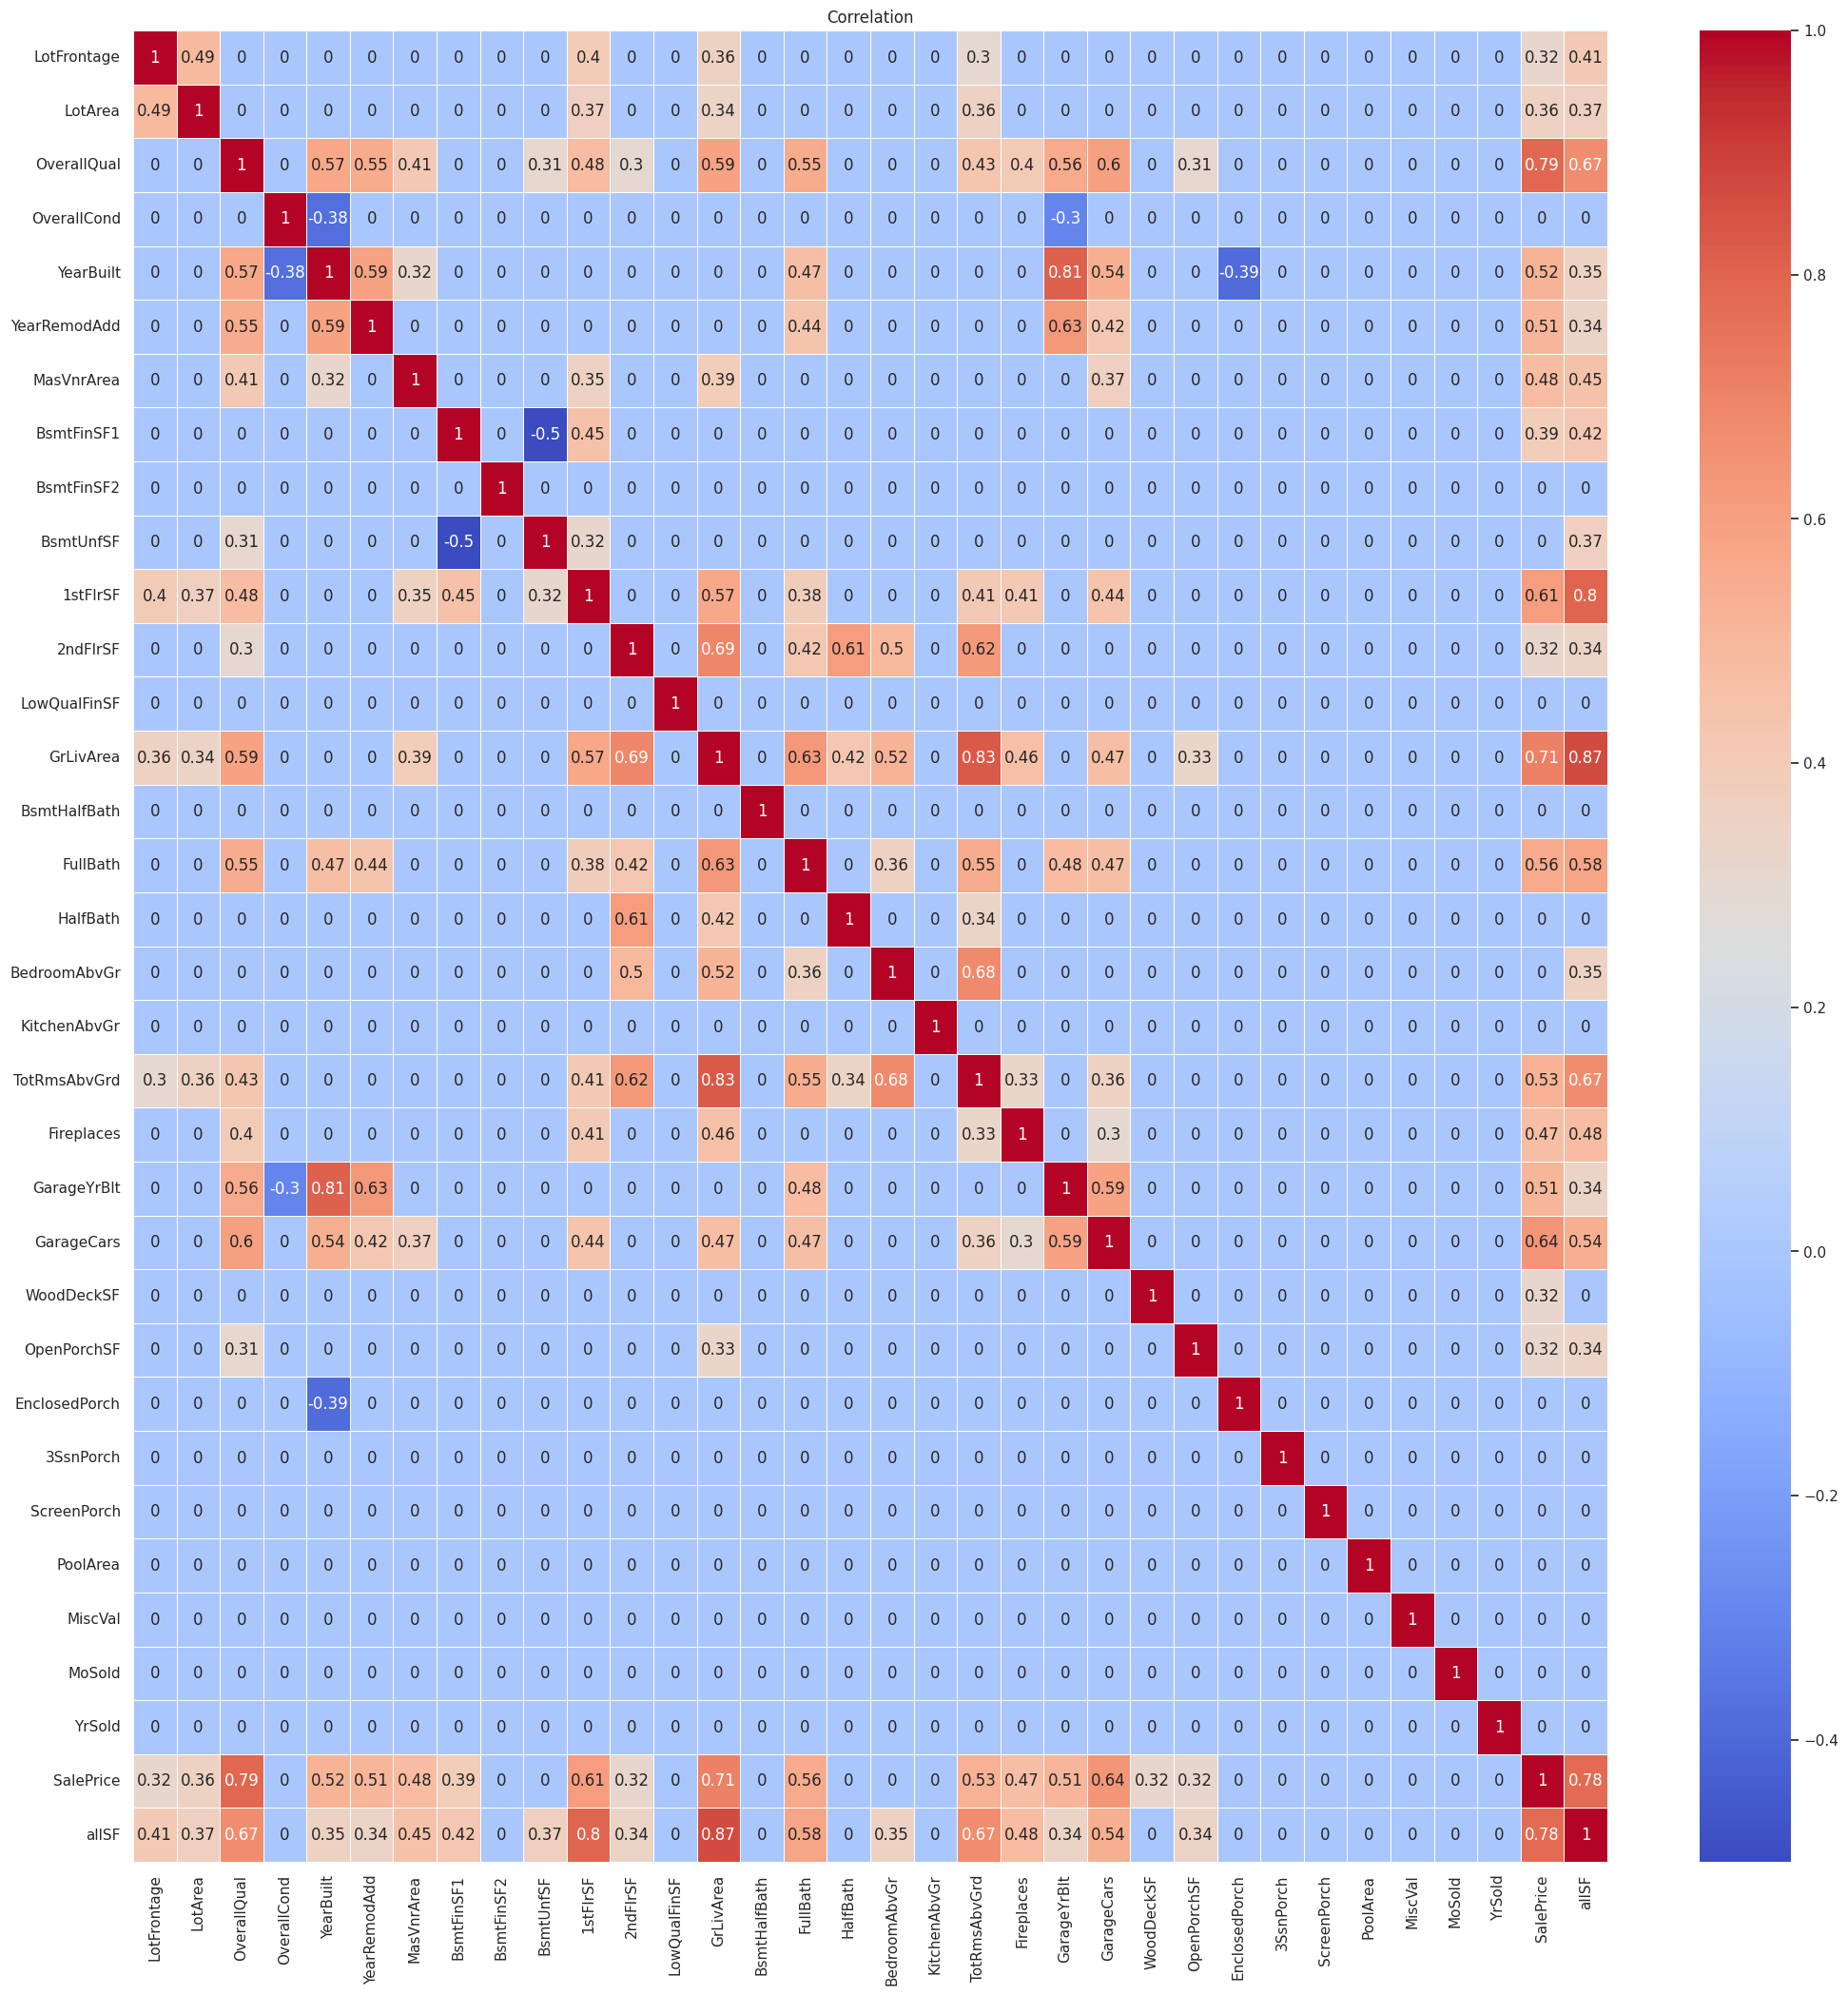

In [92]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=train[numeric_features].corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.3]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [93]:
y=train['SalePrice'].to_numpy()
train.drop(columns=['SalePrice'], inplace=True)

In [94]:
numeric_features.remove('SalePrice')

In [95]:
for col in numeric_features:
    train[col]=train[col].astype(str)
    test[col]=test[col].astype(str)

In [96]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2)

In [97]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1168, 75), (1168,), (292, 75), (292,))

In [98]:
import catboost as cb
train_dataset = cb.Pool(train,y,
                        cat_features=nonnumeric_features
)                                                     
# test_dataset = cb.Pool(x_test,y_test,          
#                        cat_features=nonnumeric_features)

In [101]:
CAT=cb.CatBoostRegressor(metric_period=100,
                         eval_metric='RMSE',
                         task_type='CPU',
                         iterations=2400, 
                         learning_rate=0.01,
                        #  early_stopping_rounds = 50,
                         depth=7,
                         
                         
                        )
history=CAT.fit(train_dataset,
        # eval_set=test_dataset
)

0:	learn: 78408.1028625	total: 29.1ms	remaining: 1m 9s
100:	learn: 46458.0070712	total: 2.94s	remaining: 1m 6s
200:	learn: 32861.3430509	total: 5.87s	remaining: 1m 4s
300:	learn: 26546.7730447	total: 8.83s	remaining: 1m 1s
400:	learn: 23061.6991653	total: 11.7s	remaining: 58.4s
500:	learn: 20789.2988219	total: 14.8s	remaining: 56s
600:	learn: 19136.4371787	total: 17.9s	remaining: 53.5s
700:	learn: 17793.6982875	total: 20.9s	remaining: 50.8s
800:	learn: 16785.3058345	total: 24s	remaining: 47.9s
900:	learn: 15983.5028509	total: 27.1s	remaining: 45.1s
1000:	learn: 15249.0202924	total: 30.2s	remaining: 42.2s
1100:	learn: 14657.1400175	total: 33.4s	remaining: 39.4s
1200:	learn: 14060.9228250	total: 36.5s	remaining: 36.4s
1300:	learn: 13518.6406929	total: 39.6s	remaining: 33.5s
1400:	learn: 12982.1354880	total: 42.7s	remaining: 30.5s
1500:	learn: 12440.6565827	total: 46s	remaining: 27.5s
1600:	learn: 11984.1078891	total: 49.2s	remaining: 24.6s
1700:	learn: 11546.9404300	total: 52.4s	remainin

In [102]:
feature_importance = CAT.get_feature_importance(train_dataset)
feature_names = train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df

,Feature,Importance
74,allSF,22.78
15,OverallQual,10.95
10,Neighborhood,6.53
44,GrLivArea,5.67
32,BsmtFinSF1,4.86
59,GarageCars,4.13
51,KitchenQual,4.12
25,ExterQual,3.02
28,BsmtQual,2.81
42,2ndFlrSF,2.56


In [103]:
y_pred_cat_train=CAT.predict(train)
y_pred_cat_test=CAT.predict(test)

In [104]:
train['Y_pred']=y_pred_cat_train
test['Y_pred']=y_pred_cat_test

In [105]:
numeric_features.append('Y_pred')

In [108]:
numeric_features.append('BsmtFullBath')
nonnumeric_features.remove('BsmtFullBath')

In [114]:
nonnumeric_features.remove('Id')

In [116]:
y2=y.copy()
train2 = train.copy()
test2 = test.copy()

In [117]:
train2.drop(columns=['Id'], inplace=True)
test2.drop(columns=['Id'], inplace=True)

In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in nonnumeric_features:
        train2[feature] = le.fit_transform(train2[feature])
        test2[feature] = le.transform(test2[feature])

In [119]:
train2=train2.astype(float)
test2=test2.astype(float)

In [120]:
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(train2, y2, test_size=0.2, random_state=2)

In [121]:
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

((1168, 75), (1168,), (292, 75), (292,))

In [124]:
from xgboost import XGBRegressor
XG=XGBRegressor(
    booster = 'gbtree',
    learning_rate = 0.01,
    colsample_bylevel = 0.5,
    colsample_bytree = 0.5,
    max_depth = 7,
    n_estimators = 1200,
    eval_metric = 'rmse',
    # early_stopping_rounds = 50,
    tree_method = 'auto'
    )

XG.fit(train2, y2,
    #    eval_set = [(x_train2, y_train2), (x_test2, y_test2)], 
       verbose = 100)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=None, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [129]:
y_pred_xg_train=XG.predict(train2)
y_pred_xg_test=XG.predict(test2)


In [130]:
importances = XG.get_booster().get_score(importance_type='weight')
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
importances

[('Y_pred', 4725.0),
 ('LotArea', 3863.0),
 ('LotFrontage', 3321.0),
 ('allSF', 2646.0),
 ('BsmtUnfSF', 2526.0),
 ('YearBuilt', 2419.0),
 ('TotalBsmtSF', 2386.0),
 ('1stFlrSF', 2317.0),
 ('GrLivArea', 2300.0),
 ('Neighborhood', 2029.0),
 ('BsmtFinSF1', 1922.0),
 ('YearRemodAdd', 1700.0),
 ('GarageYrBlt', 1507.0),
 ('MasVnrArea', 1471.0),
 ('OverallQual', 1469.0),
 ('OpenPorchSF', 1439.0),
 ('WoodDeckSF', 1354.0),
 ('OverallCond', 1335.0),
 ('MoSold', 1295.0),
 ('2ndFlrSF', 1222.0),
 ('Exterior1st', 1165.0),
 ('Exterior2nd', 977.0),
 ('YrSold', 807.0),
 ('TotRmsAbvGrd', 795.0),
 ('Condition1', 792.0),
 ('BsmtFinType1', 770.0),
 ('BsmtExposure', 762.0),
 ('HouseStyle', 761.0),
 ('LotConfig', 748.0),
 ('LotShape', 735.0),
 ('MSZoning', 681.0),
 ('EnclosedPorch', 643.0),
 ('SaleCondition', 605.0),
 ('BedroomAbvGr', 582.0),
 ('GarageCars', 568.0),
 ('LandContour', 561.0),
 ('KitchenQual', 471.0),
 ('Fireplaces', 464.0),
 ('BsmtFullBath', 448.0),
 ('RoofStyle', 429.0),
 ('FireplaceQu', 407.0

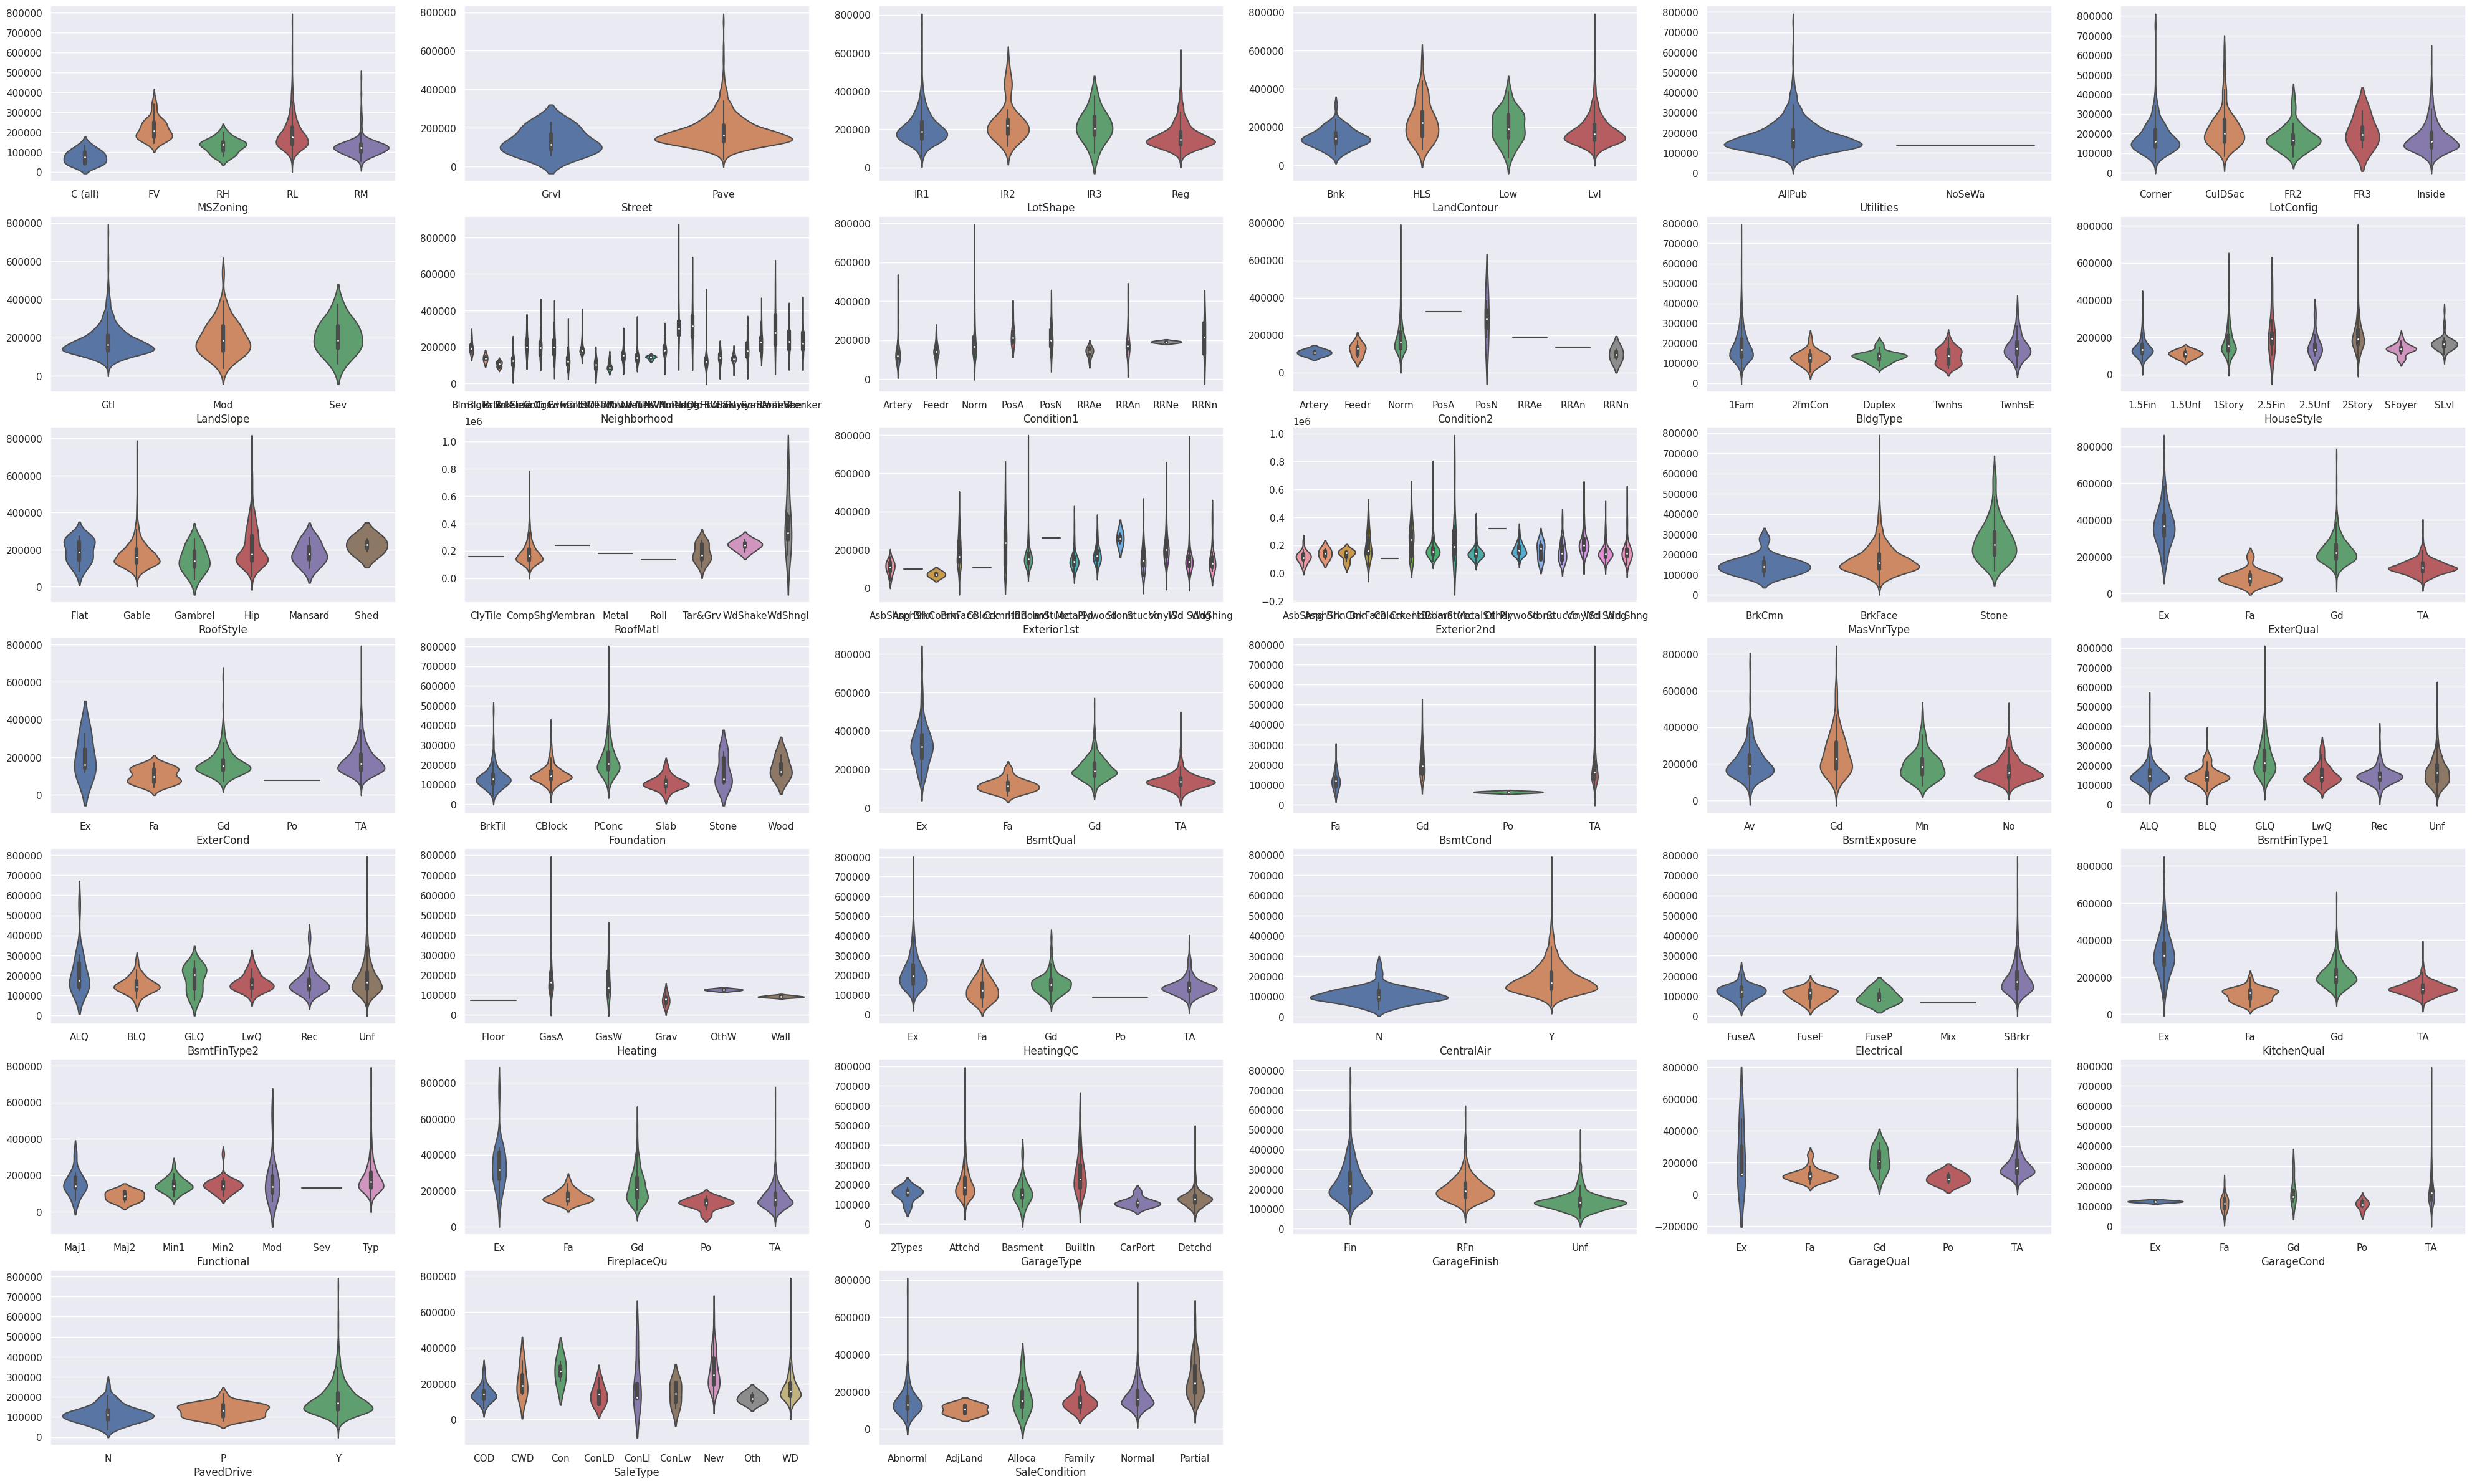

In [128]:
gs = gridspec.GridSpec(7, 6)
plt.figure(figsize=(50,30))

column=0
for i in range(7):
    column_curr=column
    for z in range(6):
        if column_curr <len(nonnumeric_features):
            ax = plt.subplot(gs[i, z])
            sns.violinplot(data=train[nonnumeric_features], x=train[nonnumeric_features].columns[column_curr], y=y2)
            ax.set_xlabel(train[nonnumeric_features].columns[column_curr])
            column_curr+=1
            column=column_curr
column+=7

plt.show()

In [132]:
new_train = pd.DataFrame({'XG_prediction': y_pred_xg_train, 'CAT_prediction': y_pred_cat_train,
                           })
new_test = pd.DataFrame({'XG_prediction': y_pred_xg_test, 'CAT_prediction': y_pred_cat_test, 
                         })
new_y=y.copy()

In [133]:
new_train

,XG_prediction,CAT_prediction
0,208330.66,204555.97
1,179890.73,182544.71
2,221642.12,212514.26
3,143608.34,163032.35
4,259539.12,276925.17
...,...,...
1455,175735.77,175834.91
1456,208147.17,210372.19
1457,266522.41,267077.92
1458,140927.58,140338.29


In [61]:
# new_train.shape, new_test.shape, new_y.shape

((1460, 2), (1459, 2), (1460,))

In [87]:
# from sklearn.model_selection import train_test_split
# x_train3, x_test3, y_train3, y_test3 = train_test_split(new_train, new_y, test_size=0.2, random_state=2)

In [137]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


estimators = [('xgboost', XG), ('catboost', CAT)]

final_estimator = LGBMRegressor()

stacking_clf = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator)

stacking_clf.fit(new_train, new_y,
                 )

0:	learn: 78739.5382778	total: 813us	remaining: 1.95s
100:	learn: 34578.6132081	total: 68.4ms	remaining: 1.56s
200:	learn: 17417.0489340	total: 137ms	remaining: 1.5s
300:	learn: 11071.4723631	total: 203ms	remaining: 1.42s
400:	learn: 8937.2395669	total: 278ms	remaining: 1.39s
500:	learn: 8131.4661004	total: 346ms	remaining: 1.31s
600:	learn: 7692.5902997	total: 415ms	remaining: 1.24s
700:	learn: 7378.5921147	total: 489ms	remaining: 1.19s
800:	learn: 7125.0407913	total: 553ms	remaining: 1.1s
900:	learn: 6939.0756280	total: 619ms	remaining: 1.03s
1000:	learn: 6818.8369537	total: 686ms	remaining: 958ms
1100:	learn: 6720.7566592	total: 753ms	remaining: 888ms
1200:	learn: 6633.8196675	total: 816ms	remaining: 815ms
1300:	learn: 6535.3089960	total: 882ms	remaining: 745ms
1400:	learn: 6430.5175149	total: 953ms	remaining: 680ms
1500:	learn: 6341.4467333	total: 1.04s	remaining: 622ms
1600:	learn: 6266.6024694	total: 1.11s	remaining: 552ms
1700:	learn: 6200.6417493	total: 1.17s	remaining: 481ms
1

StackingRegressor(estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.5,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            lea...e,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7f47b2addf50>)],
                  final_estimator=LGBMRegressor())

In [138]:
predictions=stacking_clf.predict(new_test)
predictions

array([115419.35084273, 157193.09736516, 185260.42067954, ...,
       157186.94247173, 121693.384796  , 218133.12730936])

In [139]:
# from sklearn.metrics import mean_squared_error

# rmse=np.sqrt(mean_squared_error(y_test3, predictions))
# print(rmse)

In [140]:
# predictions=CAT_final.predict(new_test)
# predictions

In [141]:
# predictions=XG.predict(new_test)
# predictions

In [142]:
output = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
output.to_csv('my_answer17.csv', index=False)